In [1]:
import pandas as pd

# Load the data
ask_data = pd.read_csv('XAGUSD_5 Mins_Ask_2023.01.01_2023.06.30.csv')
bid_data = pd.read_csv('XAGUSD_5 Mins_Bid_2023.01.01_2023.06.30.csv')

# Show the first few rows of the Ask dataset
print(ask_data.head())

            Time (UTC)    Open    High     Low   Close  Volume 
0  2023.01.02 23:00:00  24.102  24.125  24.083  24.125   0.3510
1  2023.01.02 23:05:00  24.094  24.188  24.094  24.141   1.1550
2  2023.01.02 23:10:00  24.143  24.148  24.022  24.027   0.8820
3  2023.01.02 23:15:00  24.026  24.028  23.986  24.028   0.8940
4  2023.01.02 23:20:00  24.026  24.073  24.023  24.073   0.9044


In [5]:
print(ask_data.columns)

Index(['Time (UTC)', 'Open', 'High', 'Low', 'Close', 'Volume '], dtype='object')


In [7]:
price_data = ask_data['Close'].values.reshape(-1, 1)

In [9]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(price_data)

In [11]:
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i, 0])  # Features from the previous `time_step` values
        y.append(data[i, 0])  # The next value to predict
    return np.array(X), np.array(y)

In [13]:
time_step = 60 
X, y = create_dataset(scaled_data, time_step)

X = X.reshape(X.shape[0], X.shape[1], 1)

train_size = int(len(X) * 0.8)  # 80% training data, 20% testing data
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error

# File paths (ensure the files are in the correct directory)
ask_file_path = 'XAGUSD_5 Mins_Ask_2023.01.01_2023.06.30.csv'
bid_file_path = 'XAGUSD_5 Mins_Bid_2023.01.01_2023.06.30.csv'

# Load the datasets
ask_data = pd.read_csv(ask_file_path)
bid_data = pd.read_csv(bid_file_path)

# Check the columns to ensure the correct data is being loaded
print("Ask Data Columns:", ask_data.columns)
print("Bid Data Columns:", bid_data.columns)

# Remove any leading/trailing spaces from column names
ask_data.columns = ask_data.columns.str.strip()
bid_data.columns = bid_data.columns.str.strip()

# We are using the 'Close' column for predictions
# You can choose either 'Close' from ask_data or bid_data based on the available data
price_data = ask_data['Close'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
price_data_scaled = scaler.fit_transform(price_data)

# Create time series dataset
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60  # Using 60 minutes as the time window for prediction
X, y = create_dataset(price_data_scaled, time_step)

# Reshape X to be 3D as expected by LSTM: [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

# Split data into training and testing sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=64, return_sequences=False, input_shape=(X_train.shape[1], 1)))
model.add(Dense(units=32))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Predict the prices on the test data
y_pred = model.predict(X_test)

# Inverse transform predictions and actual values
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate the Mean Absolute Error (MAE) between predictions and true values
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
print(f'Mean Absolute Error (MAE): {mae}')

# Plot the MAE graph during training
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, color='blue', label='Actual Silver Price')
plt.plot(y_pred_rescaled, color='red', label='Predicted Silver Price')
plt.title('Actual vs Predicted Silver Price')
plt.xlabel('Time')
plt.ylabel('Silver Price')
plt.legend()
plt.show()

# Predict the next 5-minute price
last_time_step = price_data_scaled[-time_step:].reshape(1, time_step, 1)
next_pred = model.predict(last_time_step)
next_pred_rescaled = scaler.inverse_transform(next_pred)

print(f"Next 5-minute predicted price: {next_pred_rescaled[0][0]}")

Ask Data Columns: Index(['Time (UTC)', 'Open', 'High', 'Low', 'Close', 'Volume '], dtype='object')
Bid Data Columns: Index(['Time (UTC)', 'Open', 'High', 'Low', 'Close', 'Volume '], dtype='object')


C:\Users\hp\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - loss: 0.0145 - val_loss: 3.9476e-05
Epoch 2/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 45s 51ms/step - loss: 5.8454e-05 - val_loss: 5.4253e-05
Epoch 3/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 39s 44ms/step - loss: 5.6201e-05 - val_loss: 3.3578e-05
Epoch 4/10
879/879 ━━━━━━━━━━━━━━━━━━━━ 46s 49ms/step - loss: 5.0375e-05 - val_loss: 2.7121e-05
Epoch 5/10
344/879 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - loss: 3.9818e-05

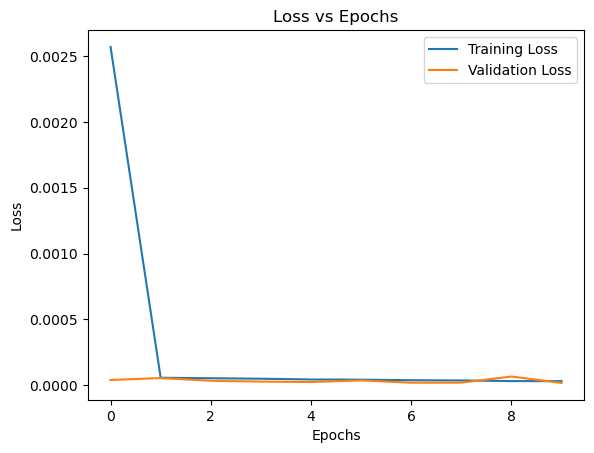

In [20]:
import matplotlib.pyplot as plt

# Assuming `history` is the training history object returned by model.fit
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()